# Промышленность

Чтобы оптимизировать производственные расходы, металлургический комбинат решил уменьшить потребление электроэнергии на этапе обработки стали. 

**Цель исследования** - построить модель, которая предскажет температуру стали.

# Описание этапа обработки

Сталь обрабатывают в металлическом ковше вместимостью около 100 тонн. Чтобы ковш выдерживал высокие температуры, изнутри его облицовывают огнеупорным кирпичом. Расплавленную сталь заливают в ковш и подогревают до нужной температуры графитовыми электродами. Они установлены в крышке ковша. 

Из сплава выводится сера (десульфурация), добавлением примесей корректируется химический состав и отбираются пробы. Сталь легируют — изменяют её состав — подавая куски сплава из бункера для сыпучих материалов или проволоку через специальный трайб-аппарат (англ. tribe, «масса»).

Перед тем как первый раз ввести легирующие добавки, измеряют температуру стали и производят её химический анализ. Потом температуру на несколько минут повышают, добавляют легирующие материалы и продувают сплав инертным газом. Затем его перемешивают и снова проводят измерения. Такой цикл повторяется до достижения целевого химического состава и оптимальной температуры плавки.
Тогда расплавленная сталь отправляется на доводку металла или поступает в машину непрерывной разливки. Оттуда готовый продукт выходит в виде заготовок-слябов (англ. slab, «плита»).


# Описание данных

Данные состоят из файлов, полученных из разных источников:
* data_arc_new.csv — данные об электродах;
* data_bulk_new.csv — данные о подаче сыпучих материалов (объём);
* data_bulk_time_new.csv — данные о подаче сыпучих материалов (время);
* data_gas_new.csv — данные о продувке сплава газом;
* data_temp_new.csv — результаты измерения температуры;
*  data_wire_new.csv — данные о проволочных материалах (объём);
* data_wire_time_new.csv — данные о проволочных материалах (время).

Во всех файлах столбец key содержит номер партии. В файлах может быть несколько строк с одинаковым значением key: они соответствуют разным итерациям обработки.


# План исследования

Исследование пройдёт в несколько этапов:

* Подготовка данных:

    * Загрузка данных
    * Изучение и анализ данных
    

* Предобработка и подготовка данных для обучения:

    * Проверка типов данных
    * Обработка пропусков
    * Создание единой таблицы
    * Проверка корреляции признаков
    * Удаление признаков, не влияющих на целевой признак
    * Создание целевого и вспомогательных признаков
    * Создание обучающей и тестовой выборки (тестовая выборка = 25%)
    
    
* Обучение моделей

    * 2-3 простых моделей
    * 2-3 модели градиентного бустинга
    * Анализ обученых моделей и выбор лучшей
    * Тестирование лучшей модели на тестовой выборке
    * Проверка модели на адекватность
    
    
* Анализ значимости признаков


* Общий вывод

## Подготовка данных

### Загрузка данных

In [1]:
# Импорт необходимых библиотек


import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import time

from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_absolute_error as mae
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, RobustScaler, PolynomialFeatures

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from sklearn.dummy import DummyRegressor

In [2]:
# Константы


r_state = 26923
figsize = (15,7)

In [3]:
# Функции и классы


# Функция для получения общих сведений о данных

def data_info(title, data):

    print('Общие сведения "{}":'.format(title))
    print()

    data.info()

    print()
    print()

    print('Пример данных (случайные 5 строк):')
    display(data.sample(5, random_state=r_state))

    print()
    print()
    
    print('Статистика данных:')
    display(data.describe(datetime_is_numeric=True))
    
    print()
    print()

    print('Количество пропусков по столбцам:')
    print()
    for col in data.columns:
        nmv = data[col].isna().sum()
        pmv = nmv/len(data)

        if pmv == 0:
            print('\033[0m{} - {} шт. - {:.2%}'.format(col, nmv, pmv))
        elif pmv <= 0.1:
            print('\033[0m{} - \033[43m{} шт.\033[0m - \033[43m{:.2%}'.format(col, nmv, pmv))
        else:
            print('\033[0m{} - \033[41m{} шт.\033[0m - \033[41m{:.2%}'.format(col, nmv, pmv))
        print('\033[0m')

    print()

    print('Количество уникальных значений в столбцах:')
    print()
    for col in data.columns:
        print('{} - {}'.format(col, data[col].nunique()))

    print()
    print()

    print('Количество явных дубликатов: {} шт.'.format(data.duplicated().sum()))

# Функция для проверки целочисленных значений в колонке

def isint(data, col):
    if (data[col].fillna(-9999) % 1  == 0).all() == True:
        print('Все числа целые')
    else:
        print('Присутствуют дробные числа')

# Функция для проверки "нулевых" колонок

def iszero(data, col, z_list):
    if data[col].sum() == 0:
        z_list.append(col)
    return z_list

# Функция для корреляции признаков

def corr_info(data, col_del, target):

    print('Корреляция признаков:')
    print()
    corr_matrix = data.drop(columns=col_del).corr()
    target_corr = corr_matrix.loc[[target],:]
    sns.set(font_scale=1.15)
    plt.figure(figsize=figsize)
    sns.heatmap(
                target_corr,
                square=True,
                cmap='RdBu_r',
                annot=True,
                vmin=-1, vmax=1,
                fmt='.1g', 
                cbar_kws= dict(use_gridspec=False, location="top"));
    plt.yticks(rotation=0) 
    #plt.xticks(rotation=45) 
    plt.show()
    print()
    for i in range(len(target_corr.columns)):
        if target_corr.columns[i] != target:
            cor = target_corr.loc[target, target_corr.columns[i]]
            print('Корреляция между {} и {}:'.format(target, target_corr.columns[i]))
            if cor == 0:
                print(f'Коэффициент корреляции: {cor:.6f} \n Свзяь отсутствует')
            elif 0 < cor <= 0.3:
                print(f'Коэффициент корреляции: {cor:.6f} \n Слабая прямая связь')
            elif -0.3 <= cor < 0:
                print(f'Коэффициент корреляции: {cor:.6f} \n Слабая обратная связь')
            elif 0.3 < cor <= 0.7:
                print(f'Коэффициент корреляции: {cor:.6f} \n Средняя прямая связь')
            elif -0.7 <= cor < -0.3:
                print(f'Коэффициент корреляции: {cor:.6f} \n Средняя обратная связь')
            elif 0.7 < cor < 1:
                print(f'Коэффициент корреляции: {cor:.6f} \n Сильная прямая связь')
            elif -1 < cor < -0.7:
                print(f'Коэффициент корреляции: {cor:.6f} \n Сильная обратная связь')
            elif cor == 1:
                print(f'Коэффициент корреляции: {cor:.6f} \n Полная прямая связь')
            elif cor == -1:
                print(f'Коэффициент корреляции: {cor:.6f} \n Полная обратная связь')
            else:
                print('Введен неверный коэффициент')
            print()
    print()
    print('Top-5 прямой связи:\n')
    print(data.corr()[target].sort_values(ascending=False)[1:].head().to_string())
    print()
    print('Top-5 обратной связи:\n')
    print(data.corr()[target].sort_values(ascending=True)[0:].head().to_string())

# Функция для отделения целевого признака

def split_target(data, target):

    features = data.drop([target] , axis=1)
    target = data[target]

    return features, target

# Функция разбивки данных для обучения

def split_data(features, target, valid_size, test_size):

    if valid_size == 0:

        features_train, features_test, target_train, target_test = train_test_split(
        features, target, test_size=test_size, random_state=r_state)

        features_list = {'features_train' : features_train, 'features_test' : features_test}
        targets_list = {'target_train' : target_train, 'target_test' : target_test}

        print('Вспомогательные признаки:')
        print()
        for i in features_list:
            sh = features_list[i].shape
            psh = sh[0]/len(data)
            print('{} - Объектов: {} шт., признаков: {} шт. - {:.2%}'.format(i, sh[0], sh[1], psh))

        print()

        print('Целевые признаки:')
        print()
        for i in targets_list:
            sh = targets_list[i].shape
            psh = sh[0]/len(data)
            print('{} - Объектов: {} шт. - {:.2%}'.format(i, sh[0], psh))

        return features_train, features_test, target_train, target_test

    else:

        valid_test_size = valid_size + test_size
        t_size = test_size / valid_test_size

        features_train, features_valid, target_train, target_valid = train_test_split(
        features, target, test_size=valid_test_size, random_state=r_state)

        features_valid, features_test, target_valid, target_test = train_test_split(
        features_valid, target_valid, test_size=t_size, random_state=r_state)

        features_list = {'features_train' : features_train,
                         'features_valid' : features_valid,
                         'features_test' : features_test}
        targets_list = {'target_train' : target_train,
                        'target_valid' : target_valid,
                        'target_test' : target_test}

        print('Вспомогательные признаки:')
        print()
        for i in features_list:
            sh = features_list[i].shape
            psh = sh[0]/len(data)
            print('{} - Объектов: {} шт., признаков: {} шт. - {:.2%}'.format(i, sh[0], sh[1], psh))

        print()

        print('Целевые признаки:')
        print()
        for i in targets_list:
            sh = targets_list[i].shape
            psh = sh[0]/len(data)
            print('{} - Объектов: {} шт. - {:.2%}'.format(i, sh[0], psh))

        return features_train, features_valid, features_test, target_train, target_valid, target_test

In [4]:
data_arc = pd.read_csv('/datasets/data_arc_new.csv', parse_dates=[1, 2])
data_bulk = pd.read_csv('/datasets/data_bulk_new.csv')
data_bulk_time = pd.read_csv('/datasets/data_bulk_time_new.csv', parse_dates=list(range(1,16)))
data_gas = pd.read_csv('/datasets/data_gas_new.csv')
data_temp = pd.read_csv('/datasets/data_temp_new.csv', parse_dates=[1])
data_wire = pd.read_csv('/datasets/data_wire_new.csv')
data_wire_time = pd.read_csv('/datasets/data_wire_time_new.csv', parse_dates=list(range(1,10)))

### Изучение и анализ данных

#### "data_arc" - данные об электродах

In [5]:
data_info('data_arc', data_arc)

Общие сведения "data_arc":

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   key                   14876 non-null  int64         
 1   Начало нагрева дугой  14876 non-null  datetime64[ns]
 2   Конец нагрева дугой   14876 non-null  datetime64[ns]
 3   Активная мощность     14876 non-null  float64       
 4   Реактивная мощность   14876 non-null  float64       
dtypes: datetime64[ns](2), float64(2), int64(1)
memory usage: 581.2 KB


Пример данных (случайные 5 строк):


,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
6621,1440,2019-06-26 13:03:37,2019-06-26 13:05:39,0.403639,0.356690
10406,2262,2019-08-01 21:28:20,2019-08-01 21:31:40,1.276612,0.890543
3336,723,2019-05-31 16:16:09,2019-05-31 16:19:03,0.819628,0.586569
4872,1051,2019-06-12 22:30:57,2019-06-12 22:34:56,0.521390,0.440412
11272,2456,2019-08-08 23:56:59,2019-08-09 00:02:37,0.759809,0.577640




Статистика данных:


,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
count,14876.000000,14876,14876,14876.000000,14876.000000
mean,1615.220422,2019-07-05 12:25:51.921081088,2019-07-05 12:28:43.592027392,0.662752,0.438986
min,1.000000,2019-05-03 11:02:14,2019-05-03 11:06:02,0.223120,-715.479924
25%,806.000000,2019-06-03 23:18:23.249999872,2019-06-03 23:21:35,0.467115,0.337175
50%,1617.000000,2019-07-03 01:31:26.500000,2019-07-03 01:35:13,0.599587,0.441639
75%,2429.000000,2019-08-07 22:52:20.750000128,2019-08-07 22:56:47,0.830070,0.608201
max,3241.000000,2019-09-06 17:24:54,2019-09-06 17:26:15,1.463773,1.270284
std,934.571502,NaN,NaN,0.258885,5.873485




Количество пропусков по столбцам:

key - 0 шт. - 0.00%

Начало нагрева дугой - 0 шт. - 0.00%

Конец нагрева дугой - 0 шт. - 0.00%

Активная мощность - 0 шт. - 0.00%

Реактивная мощность - 0 шт. - 0.00%


Количество уникальных значений в столбцах:

key - 3214
Начало нагрева дугой - 14876
Конец нагрева дугой - 14876
Активная мощность - 13846
Реактивная мощность - 14707


Количество явных дубликатов: 0 шт.


Проверим количество уникальных ключей и измерений по ним

In [6]:
data_arc['key'].value_counts()

2108    16
1689    15
1513    15
2567    14
46      13
        ..
977      1
247      1
2582     1
248      1
530      1
Name: key, Length: 3214, dtype: int64

Посмотрим данные одной партии с максимальным количеством итераций

In [7]:
data_arc[data_arc['key']==2108]

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
9734,2108,2019-07-27 10:41:13,2019-07-27 10:43:28,0.682359,0.536962
9735,2108,2019-07-27 11:07:24,2019-07-27 11:08:51,0.786992,0.582873
9736,2108,2019-07-27 11:13:37,2019-07-27 11:14:32,0.525551,0.329251
9737,2108,2019-07-27 11:15:45,2019-07-27 11:16:45,1.175194,0.789164
9738,2108,2019-07-27 11:19:26,2019-07-27 11:21:24,0.671852,0.508570
9739,2108,2019-07-27 11:23:12,2019-07-27 11:26:07,0.325151,0.217883
9740,2108,2019-07-27 13:39:32,2019-07-27 13:43:14,0.412624,0.278039
9741,2108,2019-07-27 13:45:19,2019-07-27 13:48:19,0.798390,0.616971
9742,2108,2019-07-27 13:49:36,2019-07-27 13:57:40,0.327366,0.239850
9743,2108,2019-07-27 14:01:23,2019-07-27 14:05:24,1.233412,0.855522


In [8]:
data_arc[data_arc['key']==2108].describe(datetime_is_numeric=True)

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
count,16.0,16,16,16.000000,16.000000
mean,2108.0,2019-07-27 13:32:10.687500032,2019-07-27 13:35:01.874999808,0.669175,0.474343
min,2108.0,2019-07-27 10:41:13,2019-07-27 10:43:28,0.325151,0.214661
25%,2108.0,2019-07-27 11:18:30.750000128,2019-07-27 11:20:14.249999872,0.497319,0.316448
50%,2108.0,2019-07-27 13:47:27.500000,2019-07-27 13:52:59.500000,0.663522,0.509416
75%,2108.0,2019-07-27 15:18:56.500000,2019-07-27 15:21:46.500000,0.789842,0.586732
max,2108.0,2019-07-27 16:32:17,2019-07-27 16:33:58,1.233412,0.855522
std,0.0,NaN,NaN,0.275058,0.193492


Построим график для оценки распределения активной мощности

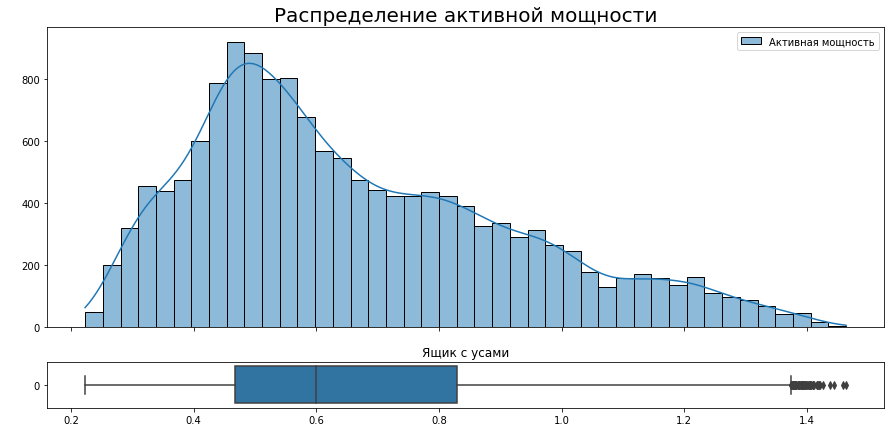

In [9]:
x = data_arc['Активная мощность']

fig, axs = plt.subplots(nrows=2,
                        ncols=1,
                        figsize=figsize,
                        sharex=True,
                        gridspec_kw=dict(height_ratios=[13,2]))

h = sns.histplot(x, label="Активная мощность", kde=True, ax=axs[0]);
h.legend();
h.set_title(label='Распределение активной мощности', fontsize=20)
h.set_xlabel('Активная мощность')
h.set_ylabel(' ')

b= sns.boxplot(data=x, orient='h', ax=axs[1])
b.set_title('Ящик с усами')
plt.show();

In [10]:
x.describe(datetime_is_numeric=True).loc[['mean', 'std']]

mean    0.662752
std     0.258885
Name: Активная мощность, dtype: float64

* Данные имеют нормальное расспределение
* Среднее значение - 0.662752
* Стандартное отклонение - 0.258885

Построим график для оценки распределения реактивной мощности, без учета аномалии 

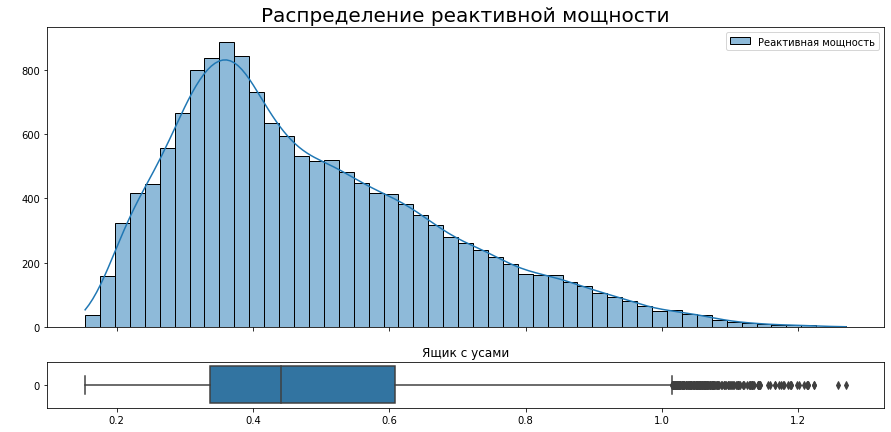

In [11]:
x = data_arc[data_arc['Реактивная мощность'] >= 0]['Реактивная мощность']

fig, axs = plt.subplots(nrows=2,
                        ncols=1,
                        figsize=figsize,
                        sharex=True,
                        gridspec_kw=dict(height_ratios=[13,2]))

h = sns.histplot(x, label="Реактивная мощность", kde=True, ax=axs[0]);
h.legend();
h.set_title(label='Распределение реактивной мощности', fontsize=20)
h.set_xlabel('Реактивная мощность')
h.set_ylabel(' ')

b= sns.boxplot(data=x, orient='h', ax=axs[1])
b.set_title('Ящик с усами')
plt.show();

In [12]:
x.describe(datetime_is_numeric=True).loc[['mean', 'std']]

mean    0.487115
std     0.197612
Name: Реактивная мощность, dtype: float64

* Данные имеют нормальное расспределение
* Среднее значение - 0.487115
* Стандартное отклонение - 0.197612

**Описание данных "data_arc":**

* Данные состоят из 14876 объектов
* Имееют 5 признаков:
    * key - номер партии
    * Начало нагрева дугой
    * Конец нагрева дугой
    * Активная мощность
    * Реактивная мощность      
* Пропуски отсутствуют
* Явные дубликаты отсутствуют
* Форматы данных соответствуют данным
* Присутствует аномалия в признаке "Реактивная мощность" = -715.479924
* Количество уникальных номеров партии = 3214 шт.
* Присутствуют строки с одинаковым значением key: они соответствуют разным итерациям обработки
* Максимальное количесвто итераций обработки = 16

####  "data_bulk" - данные о подаче сыпучих материалов (объём)

In [13]:
data_info('data_bulk', data_bulk)

Общие сведения "data_bulk":

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   Bulk 1   252 non-null    float64
 2   Bulk 2   22 non-null     float64
 3   Bulk 3   1298 non-null   float64
 4   Bulk 4   1014 non-null   float64
 5   Bulk 5   77 non-null     float64
 6   Bulk 6   576 non-null    float64
 7   Bulk 7   25 non-null     float64
 8   Bulk 8   1 non-null      float64
 9   Bulk 9   19 non-null     float64
 10  Bulk 10  176 non-null    float64
 11  Bulk 11  177 non-null    float64
 12  Bulk 12  2450 non-null   float64
 13  Bulk 13  18 non-null     float64
 14  Bulk 14  2806 non-null   float64
 15  Bulk 15  2248 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 391.2 KB


Пример данных (случайные 5 строк):


,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
2522,2618,NaN,NaN,NaN,88.0,NaN,NaN,NaN,NaN,NaN,72.0,NaN,266.0,NaN,298.0,158.0
574,603,NaN,NaN,37.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,202.0,NaN
2282,2364,NaN,NaN,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,124.0,NaN,216.0,104.0
2173,2252,NaN,NaN,NaN,110.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,106.0,NaN,135.0,105.0
1667,1727,27.0,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,511.0,NaN,218.0,NaN




Статистика данных:


,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
count,3129.000000,252.000000,22.000000,1298.000000,1014.000000,77.000000,576.000000,25.000000,1.0,19.000000,176.000000,177.000000,2450.000000,18.000000,2806.000000,2248.000000
mean,1624.383509,39.242063,253.045455,113.879045,104.394477,107.025974,118.925347,305.600000,49.0,76.315789,83.284091,76.819209,260.471020,181.111111,170.284747,160.513345
std,933.337642,18.277654,21.180578,75.483494,48.184126,81.790646,72.057776,191.022904,NaN,21.720581,26.060347,59.655365,120.649269,46.088009,65.868652,51.765319
min,1.000000,10.000000,228.000000,6.000000,12.000000,11.000000,17.000000,47.000000,49.0,63.000000,24.000000,8.000000,53.000000,151.000000,16.000000,1.000000
25%,816.000000,27.000000,242.000000,58.000000,72.000000,70.000000,69.750000,155.000000,49.0,66.000000,64.000000,25.000000,204.000000,153.250000,119.000000,105.000000
50%,1622.000000,31.000000,251.500000,97.500000,102.000000,86.000000,100.000000,298.000000,49.0,68.000000,86.500000,64.000000,208.000000,155.500000,151.000000,160.000000
75%,2431.000000,46.000000,257.750000,152.000000,133.000000,132.000000,157.000000,406.000000,49.0,70.500000,102.000000,106.000000,316.000000,203.500000,205.750000,205.000000
max,3241.000000,185.000000,325.000000,454.000000,281.000000,603.000000,503.000000,772.000000,49.0,147.000000,159.000000,313.000000,1849.000000,305.000000,636.000000,405.000000




Количество пропусков по столбцам:

key - 0 шт. - 0.00%

Bulk 1 - 2877 шт. - 91.95%

Bulk 2 - 3107 шт. - 99.30%

Bulk 3 - 1831 шт. - 58.52%

Bulk 4 - 2115 шт. - 67.59%

Bulk 5 - 3052 шт. - 97.54%

Bulk 6 - 2553 шт. - 81.59%

Bulk 7 - 3104 шт. - 99.20%

Bulk 8 - 3128 шт. - 99.97%

Bulk 9 - 3110 шт. - 99.39%

Bulk 10 - 2953 шт. - 94.38%

Bulk 11 - 2952 шт. - 94.34%

Bulk 12 - 679 шт. - 21.70%

Bulk 13 - 3111 шт. - 99.42%

Bulk 14 - 323 шт. - 10.32%

Bulk 15 - 881 шт. - 28.16%


Количество уникальных значений в столбцах:

key - 3129
Bulk 1 - 47
Bulk 2 - 15
Bulk 3 - 278
Bulk 4 - 206
Bulk 5 - 55
Bulk 6 - 205
Bulk 7 - 25
Bulk 8 - 1
Bulk 9 - 10
Bulk 10 - 77
Bulk 11 - 101
Bulk 12 - 331
Bulk 13 - 14
Bulk 14 - 284
Bulk 15 - 156


Количество явных дубликатов: 0 шт.


Проверим количество уникальных ключей и измерений по ним

In [14]:
data_bulk['key'].value_counts()

2049    1
2612    1
2588    1
541     1
2590    1
       ..
1090    1
3139    1
1092    1
3141    1
2047    1
Name: key, Length: 3129, dtype: int64

**Описание данных "data_bulk":**

* Данные состоят из 3129 объектов
* Имееют 16 признаков:
    * key - номер партии
    * 15 признаков "Bulk" о подаче сыпучих материалов (объём)
* Пропуски присутствуют во всех признаках "Bulk"
* Явные дубликаты отсутствуют
* Форматы данных соответствуют данным
* Количество уникальных номеров партии = 3129 шт.
* Все строки с уникальными значениями key
* С учетом уникальности всех строк по номерам партии, можно предположить что каждый из 15 признаков "Bulk" это уникалыный сыпучий материал, который добавляется при необходимости. Соответственно пропуски в данных признаках просто означают отсутствие добавки и их можно заменить на 0

#### "data_bulk_time" - данные о подаче сыпучих материалов (время)

In [15]:
data_info('data_bulk_time', data_bulk_time)

Общие сведения "data_bulk_time":

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   key      3129 non-null   int64         
 1   Bulk 1   252 non-null    datetime64[ns]
 2   Bulk 2   22 non-null     datetime64[ns]
 3   Bulk 3   1298 non-null   datetime64[ns]
 4   Bulk 4   1014 non-null   datetime64[ns]
 5   Bulk 5   77 non-null     datetime64[ns]
 6   Bulk 6   576 non-null    datetime64[ns]
 7   Bulk 7   25 non-null     datetime64[ns]
 8   Bulk 8   1 non-null      datetime64[ns]
 9   Bulk 9   19 non-null     datetime64[ns]
 10  Bulk 10  176 non-null    datetime64[ns]
 11  Bulk 11  177 non-null    datetime64[ns]
 12  Bulk 12  2450 non-null   datetime64[ns]
 13  Bulk 13  18 non-null     datetime64[ns]
 14  Bulk 14  2806 non-null   datetime64[ns]
 15  Bulk 15  2248 non-null   datetime64[ns]
dtypes: datetime64[ns](15), int64(1)
memory usage

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
2522,2618,NaT,NaT,NaT,2019-08-15 01:14:33,NaT,NaT,NaT,NaT,NaT,2019-08-15 01:09:17,NaT,2019-08-15 00:57:23,NaT,2019-08-15 00:52:46,2019-08-15 00:44:58
574,603,NaT,NaT,2019-05-26 08:04:19,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-26 07:52:40,NaT
2282,2364,NaT,NaT,NaT,NaT,NaT,2019-08-05 11:01:20,NaT,NaT,NaT,NaT,NaT,2019-08-05 11:06:52,NaT,2019-08-05 11:01:20,2019-08-05 10:52:25
2173,2252,NaT,NaT,NaT,2019-08-01 14:30:05,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-08-01 14:39:19,NaT,2019-08-01 14:34:51,2019-08-01 14:30:05
1667,1727,2019-07-06 17:17:20,NaT,NaT,2019-07-06 17:17:20,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-07-06 17:10:05,NaT,2019-07-06 16:55:34,NaT




Статистика данных:


,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
count,3129.000000,252,22,1298,1014,77,576,25,1,19,176,177,2450,18,2806,2248
mean,1624.383509,2019-06-29 23:24:44.769841152,2019-07-12 07:57:13.045454592,2019-07-08 13:50:14.630970624,2019-07-03 11:17:28.834319616,2019-07-13 17:18:29.090908928,2019-07-06 13:50:06.345486080,2019-07-27 18:09:05.079999744,2019-07-08 17:14:53,2019-06-23 08:08:47.578947328,2019-07-06 23:55:10.954545408,2019-07-15 07:01:00.615819264,2019-07-05 22:55:11.468571392,2019-07-01 18:32:46.944444416,2019-07-06 07:17:48.372772608,2019-07-06 13:24:51.912366336
min,1.000000,2019-05-03 17:42:46,2019-05-07 15:39:35,2019-05-03 20:40:25,2019-05-03 11:28:48,2019-05-07 15:19:17,2019-05-03 19:09:15,2019-05-07 18:11:01,2019-07-08 17:14:53,2019-05-14 11:57:58,2019-05-06 07:54:02,2019-05-05 23:43:24,2019-05-03 11:24:31,2019-05-05 02:10:21,2019-05-03 11:14:50,2019-05-03 11:10:43
25%,816.000000,2019-05-29 14:48:48.500000,2019-05-28 02:29:31.500000,2019-06-08 03:50:23.500000,2019-05-30 21:36:11.249999872,2019-06-19 23:32:44,2019-06-06 22:46:10.500000,2019-07-20 23:48:47,2019-07-08 17:14:53,2019-05-14 14:31:08,2019-06-02 05:12:00.500000,2019-06-14 20:24:48,2019-06-03 12:48:47.249999872,2019-05-29 10:43:31.249999872,2019-06-04 04:50:42,2019-06-04 11:28:18
50%,1622.000000,2019-06-25 11:09:13,2019-07-27 17:18:38.500000,2019-07-04 09:31:42,2019-06-28 03:44:42.500000,2019-07-25 17:59:41,2019-07-09 03:34:57.500000,2019-07-27 18:07:02,2019-07-08 17:14:53,2019-05-14 16:55:09,2019-07-06 07:05:20,2019-07-24 11:17:22,2019-07-03 01:32:00,2019-07-01 12:59:36.500000,2019-07-03 21:54:13.500000,2019-07-03 16:43:28.500000
75%,2431.000000,2019-07-31 05:58:18.249999872,2019-08-13 02:20:08,2019-08-11 01:00:36.750000128,2019-08-04 04:15:46.500000,2019-08-13 04:23:23,2019-08-07 18:55:01.249999872,2019-08-13 04:19:43,2019-07-08 17:14:53,2019-08-16 05:43:31,2019-08-04 02:23:35.750000128,2019-08-11 05:21:01,2019-08-08 14:55:05.249999872,2019-08-04 23:32:00.249999872,2019-08-09 04:22:40.500000,2019-08-09 09:18:31.750000128
max,3241.000000,2019-09-05 09:11:32,2019-08-13 11:47:39,2019-09-06 12:26:52,2019-09-05 03:35:21,2019-09-02 18:16:52,2019-09-06 16:24:28,2019-09-05 19:07:49,2019-07-08 17:14:53,2019-08-16 09:11:56,2019-09-04 10:03:22,2019-09-06 05:03:14,2019-09-06 15:01:44,2019-09-01 01:53:02,2019-09-06 17:26:33,2019-09-06 17:23:15
std,933.337642,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN




Количество пропусков по столбцам:

key - 0 шт. - 0.00%

Bulk 1 - 2877 шт. - 91.95%

Bulk 2 - 3107 шт. - 99.30%

Bulk 3 - 1831 шт. - 58.52%

Bulk 4 - 2115 шт. - 67.59%

Bulk 5 - 3052 шт. - 97.54%

Bulk 6 - 2553 шт. - 81.59%

Bulk 7 - 3104 шт. - 99.20%

Bulk 8 - 3128 шт. - 99.97%

Bulk 9 - 3110 шт. - 99.39%

Bulk 10 - 2953 шт. - 94.38%

Bulk 11 - 2952 шт. - 94.34%

Bulk 12 - 679 шт. - 21.70%

Bulk 13 - 3111 шт. - 99.42%

Bulk 14 - 323 шт. - 10.32%

Bulk 15 - 881 шт. - 28.16%


Количество уникальных значений в столбцах:

key - 3129
Bulk 1 - 252
Bulk 2 - 22
Bulk 3 - 1298
Bulk 4 - 1014
Bulk 5 - 77
Bulk 6 - 576
Bulk 7 - 25
Bulk 8 - 1
Bulk 9 - 19
Bulk 10 - 176
Bulk 11 - 177
Bulk 12 - 2450
Bulk 13 - 18
Bulk 14 - 2806
Bulk 15 - 2248


Количество явных дубликатов: 0 шт.


Проверим количество уникальных ключей и измерений по ним

In [16]:
data_bulk_time['key'].value_counts()

2049    1
2612    1
2588    1
541     1
2590    1
       ..
1090    1
3139    1
1092    1
3141    1
2047    1
Name: key, Length: 3129, dtype: int64

**Описание данных "data_bulk_time":**

* Данные состоят из 3129 объектов
* Имееют 16 признаков:
    * key - номер партии
    * 15 признаков "Bulk" о подаче сыпучих материалов (время)    
* Пропуски присутствуют во всех признаках "Bulk"
* Явные дубликаты отсутствуют
* Форматы данных соответствуют данным
* Количество уникальных номеров партии = 3129 шт.
* Все строки с уникальными значениями key
* С учетом уникальности всех строк по номерам партии, можно предположить что каждый из 15 признаков "Bulk" это уникалыный сыпучий материал, который добавляется при необходимости. Соответственно пропуски в данных признаках просто означают отсутствие добавки и их можно заменить на 0

#### "data_gas" - данные о продувке сплава газом

In [17]:
data_info('data_gas', data_gas)

Общие сведения "data_gas":

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3239 non-null   int64  
 1   Газ 1   3239 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB


Пример данных (случайные 5 строк):


,key,Газ 1
2618,2621,6.504235
1484,1487,1.979604
578,581,26.295454
1122,1125,5.810964
865,868,6.461385




Статистика данных:


,key,Газ 1
count,3239.000000,3239.000000
mean,1621.861377,11.002062
std,935.386334,6.220327
min,1.000000,0.008399
25%,812.500000,7.043089
50%,1622.000000,9.836267
75%,2431.500000,13.769915
max,3241.000000,77.995040




Количество пропусков по столбцам:

key - 0 шт. - 0.00%

Газ 1 - 0 шт. - 0.00%


Количество уникальных значений в столбцах:

key - 3239
Газ 1 - 3239


Количество явных дубликатов: 0 шт.


Проверим количество уникальных ключей и измерений по ним

In [18]:
data_gas['key'].value_counts()

2049    1
3135    1
3115    1
1070    1
3119    1
       ..
2596    1
549     1
2600    1
553     1
2047    1
Name: key, Length: 3239, dtype: int64

Построим график для оценки распределения газа

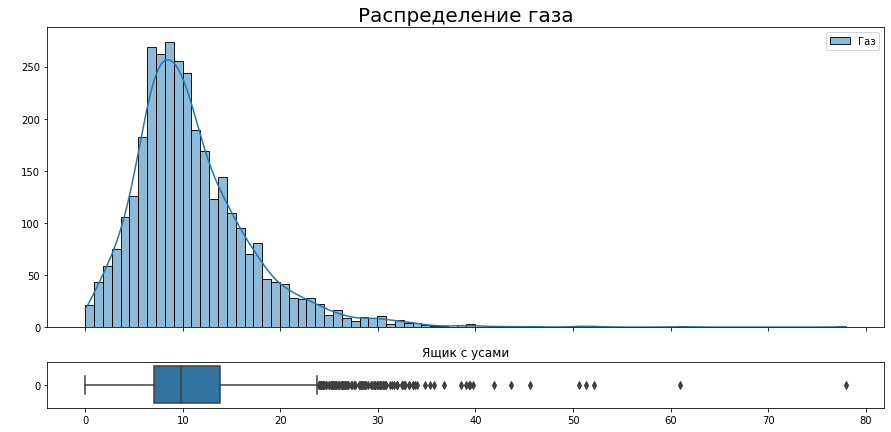

In [19]:
x = data_gas['Газ 1']

fig, axs = plt.subplots(nrows=2,
                        ncols=1,
                        figsize=figsize,
                        sharex=True,
                        gridspec_kw=dict(height_ratios=[13,2]))

h = sns.histplot(x, label="Газ", kde=True, ax=axs[0]);
h.legend();
h.set_title(label='Распределение газа', fontsize=20)
h.set_xlabel('Газ')
h.set_ylabel(' ')

b= sns.boxplot(data=x, orient='h', ax=axs[1])
b.set_title('Ящик с усами')
plt.show();

In [20]:
x.describe(datetime_is_numeric=True).loc[['mean', 'std']]

mean    11.002062
std      6.220327
Name: Газ 1, dtype: float64

* Данные имеют нормальное расспределение
* Среднее значение - 11.002062
* Стандартное отклонение - 6.220327

**Описание данных "data_gas":**

* Данные состоят из 3239 объектов
* Имееют 2 признаков:
    * key - номер партии
    * Газ 1 - продувка газом
* Пропуски отсутствуют
* Явные дубликаты отсутствуют
* Форматы данных соответствуют данным
* Количество уникальных номеров партии = 3239 шт.
* Все строки с уникальными значениями key

#### "data_temp" - результаты измерения температуры

In [21]:
data_info('data_temp', data_temp)

Общие сведения "data_temp":

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18092 entries, 0 to 18091
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   key           18092 non-null  int64         
 1   Время замера  18092 non-null  datetime64[ns]
 2   Температура   14665 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 424.2 KB


Пример данных (случайные 5 строк):


,key,Время замера,Температура
5557,989,2019-06-10 16:47:01,1584.0
1518,274,2019-05-14 04:38:43,1591.0
15496,2770,2019-08-20 19:07:45,1585.0
2825,500,2019-05-22 16:08:23,1579.0
5675,1010,2019-06-11 10:28:13,1573.0




Статистика данных:


,key,Время замера,Температура
count,18092.000000,18092,14665.000000
mean,1616.460977,2019-07-05 13:36:58.791620608,1590.722741
min,1.000000,2019-05-03 11:02:04,1191.000000
25%,807.750000,2019-06-04 00:35:01.249999872,1580.000000
50%,1618.000000,2019-07-03 02:11:48,1590.000000
75%,2429.000000,2019-08-07 23:10:05.249999872,1599.000000
max,3241.000000,2019-09-06 17:30:05,1705.000000
std,934.641385,NaN,20.394381




Количество пропусков по столбцам:

key - 0 шт. - 0.00%

Время замера - 0 шт. - 0.00%

Температура - 3427 шт. - 18.94%


Количество уникальных значений в столбцах:

key - 3216
Время замера - 18092
Температура - 172


Количество явных дубликатов: 0 шт.


Проверим количество уникальных ключей и измерений по ним

In [22]:
data_temp['key'].value_counts()

2108    17
1513    16
1689    16
2567    15
322     14
        ..
556      2
1169     2
732      2
195      1
279      1
Name: key, Length: 3216, dtype: int64

Посмотрим данные без замера температур

In [23]:
data_temp[data_temp['Температура'].isnull()]

,key,Время замера,Температура
13927,2500,2019-08-10 14:13:11,NaN
13928,2500,2019-08-10 14:18:12,NaN
13929,2500,2019-08-10 14:25:53,NaN
13930,2500,2019-08-10 14:29:39,NaN
13932,2501,2019-08-10 14:49:15,NaN
...,...,...,...
18087,3241,2019-09-06 16:55:01,NaN
18088,3241,2019-09-06 17:06:38,NaN
18089,3241,2019-09-06 17:21:48,NaN
18090,3241,2019-09-06 17:24:44,NaN


Проверим данные по ключу (с количеством итераций больше 1) без замера температур

In [24]:
data_temp[data_temp['key']==2500]

,key,Время замера,Температура
13926,2500,2019-08-10 14:04:39,1539.0
13927,2500,2019-08-10 14:13:11,NaN
13928,2500,2019-08-10 14:18:12,NaN
13929,2500,2019-08-10 14:25:53,NaN
13930,2500,2019-08-10 14:29:39,NaN


Проверим данные по ключу (с максимальным количеством итераций)

In [25]:
data_temp[data_temp['key']==2108]

,key,Время замера,Температура
11825,2108,2019-07-27 10:41:03,1639.0
11826,2108,2019-07-27 11:07:14,1626.0
11827,2108,2019-07-27 11:13:27,1604.0
11828,2108,2019-07-27 11:15:35,1612.0
11829,2108,2019-07-27 11:19:16,1621.0
11830,2108,2019-07-27 11:23:02,1535.0
11831,2108,2019-07-27 13:39:22,1577.0
11832,2108,2019-07-27 13:45:09,1585.0
11833,2108,2019-07-27 13:49:26,1559.0
11834,2108,2019-07-27 14:01:13,1562.0


In [26]:
print('Количество аномалий температуры (меньше 1500 градусов):')
data_temp[data_temp['Температура']<1500]['key'].count()

Количество аномалий температуры (меньше 1500 градусов):


5

Построим график для оценки распределения температуры, без учета аномалии

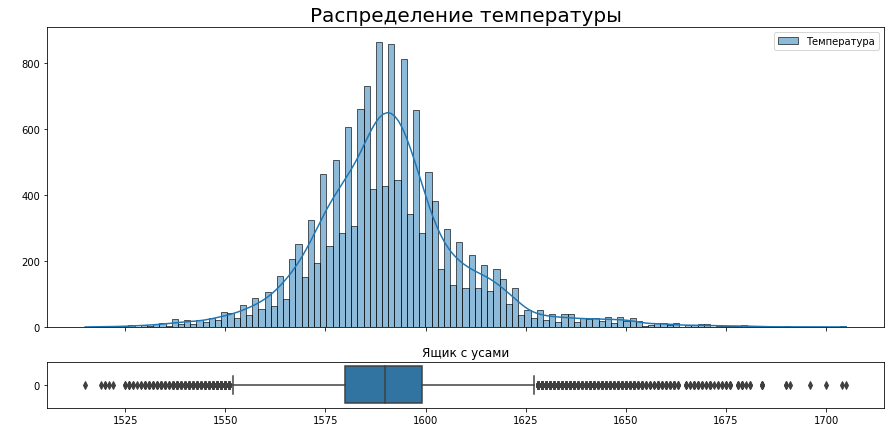

In [27]:
x = data_temp[data_temp['Температура']>1500]['Температура']

fig, axs = plt.subplots(nrows=2,
                        ncols=1,
                        figsize=figsize,
                        sharex=True,
                        gridspec_kw=dict(height_ratios=[13,2]))

h = sns.histplot(x, label="Температура", kde=True, ax=axs[0]);
h.legend();
h.set_title(label='Распределение температуры', fontsize=20)
h.set_xlabel('Температура')
h.set_ylabel(' ')

b= sns.boxplot(data=x, orient='h', ax=axs[1])
b.set_title('Ящик с усами')
plt.show();

In [28]:
x.describe(datetime_is_numeric=True).loc[['mean', 'std']]

mean    1590.852729
std       19.143141
Name: Температура, dtype: float64

* Данные имеют нормальное расспределение
* Среднее значение - 1590.852729
* Стандартное отклонение - 19.143141

**Описание данных "data_temp":**

* Данные состоят из 18092 объектов
* Имееют 3 признака:
    * key - номер партии
    * Время замера
    * Температура
* Присутствуют пропуски в признаке "Температура". Вероятно, в некоторых партиях повторные замеры на новых итерациях обработки не проводились, можно заменить на 0
* Явные дубликаты отсутствуют
* Формат признака "Температура" возможно стоит перевести в целое
* Остальные форматы данных соответствуют данным
* Количество уникальных номеров партии = 3214 шт.
* Присутствуют строки с одинаковым значением key: они соответствуют разным итерациям обработки
* Максимальное количесвто итераций обработки = 16
* По информации от заказчика температура плавления нашего металла 1500 градусов, все что ниже аномалии, т.е. данные где температуры ниже 1500 градусов удалим (таких данных 5 строк)

#### "data_wire" - данные о проволочных материалах (объём)

In [29]:
data_info('data_wire', data_wire)

Общие сведения "data_wire":

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   Wire 1  3055 non-null   float64
 2   Wire 2  1079 non-null   float64
 3   Wire 3  63 non-null     float64
 4   Wire 4  14 non-null     float64
 5   Wire 5  1 non-null      float64
 6   Wire 6  73 non-null     float64
 7   Wire 7  11 non-null     float64
 8   Wire 8  19 non-null     float64
 9   Wire 9  29 non-null     float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB


Пример данных (случайные 5 строк):


,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
1048,1114,65.005203,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
189,207,107.059677,15.142401,NaN,NaN,NaN,NaN,NaN,NaN,NaN
164,180,56.259841,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
872,926,77.547600,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1369,1441,130.103988,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN




Статистика данных:


,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
count,3081.000000,3055.000000,1079.000000,63.000000,14.000000,1.000,73.000000,11.000000,19.000000,29.000000
mean,1623.426485,100.895853,50.577323,189.482681,57.442841,15.132,48.016974,10.039007,53.625193,34.155752
std,932.996726,42.012518,39.320216,99.513444,28.824667,NaN,33.919845,8.610584,16.881728,19.931616
min,1.000000,1.918800,0.030160,0.144144,24.148801,15.132,0.034320,0.234208,45.076721,4.622800
25%,823.000000,72.115684,20.193680,95.135044,40.807002,15.132,25.053600,6.762756,46.094879,22.058401
50%,1619.000000,100.158234,40.142956,235.194977,45.234282,15.132,42.076324,9.017009,46.279999,30.066399
75%,2434.000000,126.060483,70.227558,276.252014,76.124619,15.132,64.212723,11.886057,48.089603,43.862003
max,3241.000000,330.314424,282.780152,385.008668,113.231044,15.132,180.454575,32.847674,102.762401,90.053604




Количество пропусков по столбцам:

key - 0 шт. - 0.00%

Wire 1 - 26 шт. - 0.84%

Wire 2 - 2002 шт. - 64.98%

Wire 3 - 3018 шт. - 97.96%

Wire 4 - 3067 шт. - 99.55%

Wire 5 - 3080 шт. - 99.97%

Wire 6 - 3008 шт. - 97.63%

Wire 7 - 3070 шт. - 99.64%

Wire 8 - 3062 шт. - 99.38%

Wire 9 - 3052 шт. - 99.06%


Количество уникальных значений в столбцах:

key - 3081
Wire 1 - 2251
Wire 2 - 713
Wire 3 - 56
Wire 4 - 14
Wire 5 - 1
Wire 6 - 69
Wire 7 - 10
Wire 8 - 13
Wire 9 - 25


Количество явных дубликатов: 0 шт.


Проверим количество уникальных ключей и измерений по ним

In [30]:
data_wire['key'].value_counts()

2049    1
2664    1
2590    1
543     1
2592    1
       ..
1090    1
3139    1
1092    1
3141    1
2047    1
Name: key, Length: 3081, dtype: int64

**Описание данных "data_wire":**

* Данные состоят из 3081 объекта
* Имееют 10 признаков:
    * key - номер партии
    * 9 признаков "Wire" о проволочных материалах (объём)
* Пропуски присутствуют во всех признаках "Wire"
* Явные дубликаты отсутствуют
* Форматы данных соответствуют данным
* Количество уникальных номеров партии = 3081 шт.
* Все строки с уникальными значениями key
* С учетом уникальности всех строк по номерам партии, можно предположить что каждый из 10 признаков "Wire" это уникалыный проволочный материал, который добавляется при необходимости. Соответственно пропуски в данных признаках просто означают отсутствие добавки, можно заменить на 0

#### "data_wire_time" - данные о проволочных материалах (время)

In [31]:
data_info('data_wire_time', data_wire_time)

Общие сведения "data_wire_time":

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   key     3081 non-null   int64         
 1   Wire 1  3055 non-null   datetime64[ns]
 2   Wire 2  1079 non-null   datetime64[ns]
 3   Wire 3  63 non-null     datetime64[ns]
 4   Wire 4  14 non-null     datetime64[ns]
 5   Wire 5  1 non-null      datetime64[ns]
 6   Wire 6  73 non-null     datetime64[ns]
 7   Wire 7  11 non-null     datetime64[ns]
 8   Wire 8  19 non-null     datetime64[ns]
 9   Wire 9  29 non-null     datetime64[ns]
dtypes: datetime64[ns](9), int64(1)
memory usage: 240.8 KB


Пример данных (случайные 5 строк):


,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
1048,1114,2019-06-14 23:55:01,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
189,207,2019-05-11 09:58:13,2019-05-11 09:53:42,NaT,NaT,NaT,NaT,NaT,NaT,NaT
164,180,2019-05-10 13:00:19,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
872,926,2019-06-08 07:12:11,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
1369,1441,2019-06-26 13:26:36,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT




Статистика данных:


,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
count,3081.000000,3055,1079,63,14,1,73,11,19,29
mean,1623.426485,2019-07-05 23:22:34.279541760,2019-07-07 01:07:08.735866624,2019-07-10 15:09:58.650793472,2019-07-11 13:44:37,2019-08-13 06:14:30,2019-07-07 11:51:15.095890432,2019-08-07 01:16:08.090909184,2019-06-23 07:47:49.052631552,2019-07-01 11:56:04.793103616
min,1.000000,2019-05-03 11:06:19,2019-05-03 13:15:34,2019-05-04 04:34:27,2019-05-07 15:19:17,2019-08-13 06:14:30,2019-05-07 14:46:05,2019-07-27 05:49:05,2019-05-14 11:29:24,2019-05-04 17:21:27
25%,823.000000,2019-06-04 19:30:11.500000,2019-06-05 14:50:26.500000,2019-06-11 14:17:38.500000,2019-07-20 17:58:53.750000128,2019-08-13 06:14:30,2019-05-08 21:47:30,2019-07-27 16:27:27,2019-05-14 14:20:07.500000,2019-06-09 19:36:17
50%,1619.000000,2019-07-03 06:36:23,2019-07-04 23:13:39,2019-07-21 10:04:47,2019-07-27 05:45:26.500000,2019-08-13 06:14:30,2019-07-28 05:00:32,2019-08-12 21:48:11,2019-05-14 16:55:09,2019-06-11 10:10:21
75%,2434.000000,2019-08-08 08:56:06.500000,2019-08-08 23:15:17,2019-08-12 22:54:46,2019-07-27 16:20:04.750000128,2019-08-13 06:14:30,2019-08-13 13:33:02,2019-08-13 02:02:55.500000,2019-08-16 05:06:53.500000,2019-08-09 06:49:04
max,3241.000000,2019-09-06 17:10:06,2019-09-06 07:35:40,2019-09-02 07:14:44,2019-08-13 03:16:45,2019-08-13 06:14:30,2019-08-18 19:10:56,2019-08-13 10:25:22,2019-08-16 08:56:23,2019-09-03 12:55:23
std,932.996726,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN




Количество пропусков по столбцам:

key - 0 шт. - 0.00%

Wire 1 - 26 шт. - 0.84%

Wire 2 - 2002 шт. - 64.98%

Wire 3 - 3018 шт. - 97.96%

Wire 4 - 3067 шт. - 99.55%

Wire 5 - 3080 шт. - 99.97%

Wire 6 - 3008 шт. - 97.63%

Wire 7 - 3070 шт. - 99.64%

Wire 8 - 3062 шт. - 99.38%

Wire 9 - 3052 шт. - 99.06%


Количество уникальных значений в столбцах:

key - 3081
Wire 1 - 3055
Wire 2 - 1079
Wire 3 - 63
Wire 4 - 14
Wire 5 - 1
Wire 6 - 73
Wire 7 - 11
Wire 8 - 19
Wire 9 - 29


Количество явных дубликатов: 0 шт.


Проверим количество уникальных ключей и измерений по ним

In [32]:
data_wire_time['key'].value_counts()

2049    1
2664    1
2590    1
543     1
2592    1
       ..
1090    1
3139    1
1092    1
3141    1
2047    1
Name: key, Length: 3081, dtype: int64

**Описание данных "data_wire_time":**

* Данные состоят из 3081 объектов
* Имееют 10 признаков:
    * key - номер партии
    * 9 признаков "Wire" о проволочных материалах (время)    
* Пропуски присутствуют во всех признаках "Wire"
* Явные дубликаты отсутствуют
* Форматы данных соответствуют данным
* Количество уникальных номеров партии = 3129 шт.
* Все строки с уникальными значениями key
* С учетом уникальности всех строк по номерам партии, можно предположить что каждый из 9 признаков "Wire" это уникалыный проволочный материал, который добавляется при необходимости. Соответственно пропуски в данных признаках просто означают отсутствие добавки, можно заменить на 0

#### Вывод по разделу "Изучение и анализ данных"

* Все нужные признаки необходимо объеденить в одну **итоговую таблицу** для обучения
* **Названия признаков** в разных таблицах имеют разный стиль и язык. В итоговой таблице можно все признаки привести к единому стилю, но возможно заказчику удобнее воспринимать в том виде, в котором были предоставлены данные. (В текущем проекте оставим как есть, в реальной жизни нужно было бы уточнить этот момент у заказчика)
* Количество уникальных ключей **"key"** во всех данных разное, значит в итоговой таблице для обучения оставим максимум 3081 наблюдение
* **data_arc:** 
    * Можно создать признак "время нагрева дугой" (длительность)
    * Можно создать признак "полная мощность" и удалить активную и реактивную мощности. Полная мощность рассчитывается по формуле: $S=\sqrt{P^2+Q^2}$, где $S$ - Полная мощность, $P$ - Активная мощность, $Q$ - Реактивная мощность
    * В данных, где по одному ключу больше одного измерения агрегируем по среднему значению
* **data_bulk и data_wire:**
    * Пропуски в данных заменим на значение 0
* **data_bulk_time и data_wire_time** - не будем использовать при обучении
* **data_gas** - оставляем как есть
* **data_temp:**
    * Содержит целевой признак - финальную температуру
    * Не будем использовать для обучения промежуточные измерения температуры
    * Начальную температуру оставим для обучения в качестве отдельного признака
    * Можно создать признак "Длительность замеров"

## Предобработка и подготовка данных для обучения

### Обработка пропусков и аномалий

Аномалии присутствуют в признаках:
* "Реактивная мощность" таблицы *data_arc* (значения меньше 0)
* "Температура" таблицы *data_temp* (значения меньше 1500)
* Удалим все замеры партии с аномалями

Пропуски присутствуют в признаках:
* "Bulk 1-15" таблицы *data_bulk* (заменим на 0)
* "Bulk 1-15" таблицы *data_bulk_time* (данные не будут использоваться для обучения, оставим как есть)
* "Температура" таблицы *data_temp* (партии с одним измерением не будут использоваться для обучения, в нашем случае пропуски означают отсутствие измерений, удалим все пропуски)
* "Wire 1-9" таблицы *data_wire* (заменим на 0)
* "Wire 1-9" таблицы *data_wire_time* (данные не будут использоваться для обучения, оставим как есть)

Удалим все замеры партии с аномалями

In [33]:
key_zero = data_arc[data_arc['Реактивная мощность']<=0]['key'].unique()
data_arc = data_arc[~data_arc['key'].isin(key_zero)]

In [34]:
key_zero = data_temp[data_temp['Температура']<=1500]['key'].unique()
data_temp = data_temp[~data_temp['key'].isin(key_zero)]

Избавимся от пропусков

In [37]:
data_bulk = data_bulk.fillna(0)
data_wire = data_wire.fillna(0)
data_temp = data_temp.fillna(0)

### Проверка типов данных

* При загрузке данных мы сразу изменили тип данных на data, где это было необходимо
* Нужно проверить и при необходимости заменить на целочисленный тип данных признак "Температура" в таблице *data_temp* и признаки "Bulk 1-15" в таблице *data_bulk*
* Остальные типы данных соответствуют значениям

Проверим столбец "Температура":

In [38]:
isint(data_temp, 'Температура')

Все числа целые


Проверим столбцы "Bulk":

In [39]:
for i in range(1, len(data_bulk.axes[1])):
  print('Bulk ' + str(i))
  isint(data_bulk, 'Bulk '+ str(i))

Bulk 1
Все числа целые
Bulk 2
Все числа целые
Bulk 3
Все числа целые
Bulk 4
Все числа целые
Bulk 5
Все числа целые
Bulk 6
Все числа целые
Bulk 7
Все числа целые
Bulk 8
Все числа целые
Bulk 9
Все числа целые
Bulk 10
Все числа целые
Bulk 11
Все числа целые
Bulk 12
Все числа целые
Bulk 13
Все числа целые
Bulk 14
Все числа целые
Bulk 15
Все числа целые


Все значения в признаках являются int (целочисленными), хотя формат установлен float (дробные, с плавающей точкой). 
Изменим тип данных на более подходящий


In [40]:
data_temp['Температура'] = data_temp['Температура'].astype(int)

In [41]:
for i in range(1, len(data_bulk.axes[1])):
  data_bulk['Bulk ' + str(i)] = data_bulk['Bulk ' + str(i)].astype(int)

### Создание единой таблицы

#### Создадим новые признаки

In [42]:
data_arc['Время нагрева'] = (data_arc['Конец нагрева дугой'] - data_arc['Начало нагрева дугой']).dt.seconds

data_arc['Полная мощность'] = np.sqrt(data_arc['Активная мощность']**2 + data_arc['Реактивная мощность']**2)

data_arc = (data_arc.drop(['Активная мощность', 'Реактивная мощность', 'Начало нагрева дугой', 'Конец нагрева дугой'], axis=1)
            .groupby('key')
            .agg({'Время нагрева' : 'mean', 'Полная мощность' : 'mean'})
            .reset_index())

data_arc

,key,Время нагрева,Полная мощность
0,1,219.60,0.743747
1,2,202.75,0.647087
2,3,131.00,1.003845
3,4,185.25,0.850010
4,5,217.25,0.704245
...,...,...,...
3208,3237,181.80,0.650131
3209,3238,182.00,0.574646
3210,3239,152.00,0.751810
3211,3240,167.80,0.816584


In [43]:
def max_min(x):
    return (x.max() - x.min()).seconds

data_temp = (data_temp[data_temp['key']
            .duplicated(keep=False) == True]
            .sort_values(by=['key', 'Время замера'])
            .groupby(by ='key')
            .agg({'Температура' : ['first', 'last'], 'Время замера' : max_min})
            .reset_index())

data_temp.columns = data_temp.columns.droplevel()
data_temp.columns = ['key', 'Начальная температура', 'Финальная температура', 'Длительность измерений']

data_temp

,key,Начальная температура,Финальная температура,Длительность измерений
0,1,1571,1613,1714
1,2,1581,1602,1265
2,3,1596,1599,1753
3,4,1601,1625,1220
4,5,1576,1602,1536
...,...,...,...,...
3204,3237,1569,0,1470
3205,3238,1584,0,1102
3206,3239,1598,0,3185
3207,3240,1617,0,4205


In [44]:
key_zero = data_temp[(data_temp['Начальная температура']==0) | (data_temp['Финальная температура']==0)]['key'].unique()
data_temp = data_temp[~data_temp['key'].isin(key_zero)]
data_temp

,key,Начальная температура,Финальная температура,Длительность измерений
0,1,1571,1613,1714
1,2,1581,1602,1265
2,3,1596,1599,1753
3,4,1601,1625,1220
4,5,1576,1602,1536
...,...,...,...,...
2466,2495,1570,1591,1380
2467,2496,1554,1591,1705
2468,2497,1571,1589,962
2469,2498,1591,1594,1520


#### Создадим единую таблицу

In [45]:
data = (data_arc
        .merge(right=data_bulk, how='inner', on='key')
        .merge(right=data_wire, how='inner', on='key')
        .merge(right=data_gas, how='inner', on='key')
        .merge(right=data_temp, how='inner', on='key'))
data

,key,Время нагрева,Полная мощность,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,...,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9,Газ 1,Начальная температура,Финальная температура,Длительность измерений
0,1,219.600000,0.743747,0,0,0,43,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,29.749986,1571,1613,1714
1,2,202.750000,0.647087,0,0,0,73,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,12.555561,1581,1602,1265
2,3,131.000000,1.003845,0,0,0,34,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,28.554793,1596,1599,1753
3,4,185.250000,0.850010,0,0,0,81,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,18.841219,1601,1625,1220
4,5,217.250000,0.704245,0,0,0,78,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,5.413692,1576,1602,1536
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2319,2495,180.750000,0.967180,0,0,21,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,7.125735,1570,1591,1380
2320,2496,156.666667,0.845053,0,0,0,63,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,9.412616,1554,1591,1705
2321,2497,189.666667,1.453639,0,0,0,85,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,6.271699,1571,1589,962
2322,2498,150.000000,0.781983,0,0,90,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,14.953657,1591,1594,1520


Переименуем все признаки в единый стиль

In [46]:
data.rename(columns={'Время нагрева' : 'heat_time', 
                     'Полная мощность' : 'full_power',
                     'Bulk 1' : 'bulk_1',
                     'Bulk 2' : 'bulk_2',
                     'Bulk 3' : 'bulk_3',
                     'Bulk 4' : 'bulk_4',
                     'Bulk 5' : 'bulk_5',
                     'Bulk 6' : 'bulk_6',
                     'Bulk 7' : 'bulk_7',
                     'Bulk 8' : 'bulk_8',
                     'Bulk 9' : 'bulk_9',
                     'Bulk 10' : 'bulk_10',
                     'Bulk 11' : 'bulk_11',
                     'Bulk 12' : 'bulk_12',
                     'Bulk 13' : 'bulk_13',
                     'Bulk 14' : 'bulk_14',
                     'Bulk 15' : 'bulk_15',
                     'Wire 1' : 'wire_1',
                     'Wire 2' : 'wire_2',
                     'Wire 3' : 'wire_3',
                     'Wire 4' : 'wire_4',
                     'Wire 5' : 'wire_5',
                     'Wire 6' : 'wire_6',
                     'Wire 7' : 'wire_7',
                     'Wire 8' : 'wire_8',
                     'Wire 9' : 'wire_9',
                     'Газ 1' : 'gas',
                     'Начальная температура' : 'start_temp',
                     'Финальная температура' : 'final_temp',
                     'Длительность измерений' : 'measur_duration'},
            inplace=True)

После объединения данных признак "key" нам больше не потребуется. Удалим его

In [47]:
data = data.drop('key', axis=1)

Проверим все признаки на наличие "нулевых"

In [48]:
zero_list = []

for col in data:
    zero_list = iszero(data, col, zero_list)
    
print('Список нулевых столбцов:', zero_list)

Список нулевых столбцов: ['wire_5']


Удалим "нулевой" признак

In [49]:
data = data.drop(zero_list, axis=1)

#### Корреляция данных

Оценим корреляцию признаков

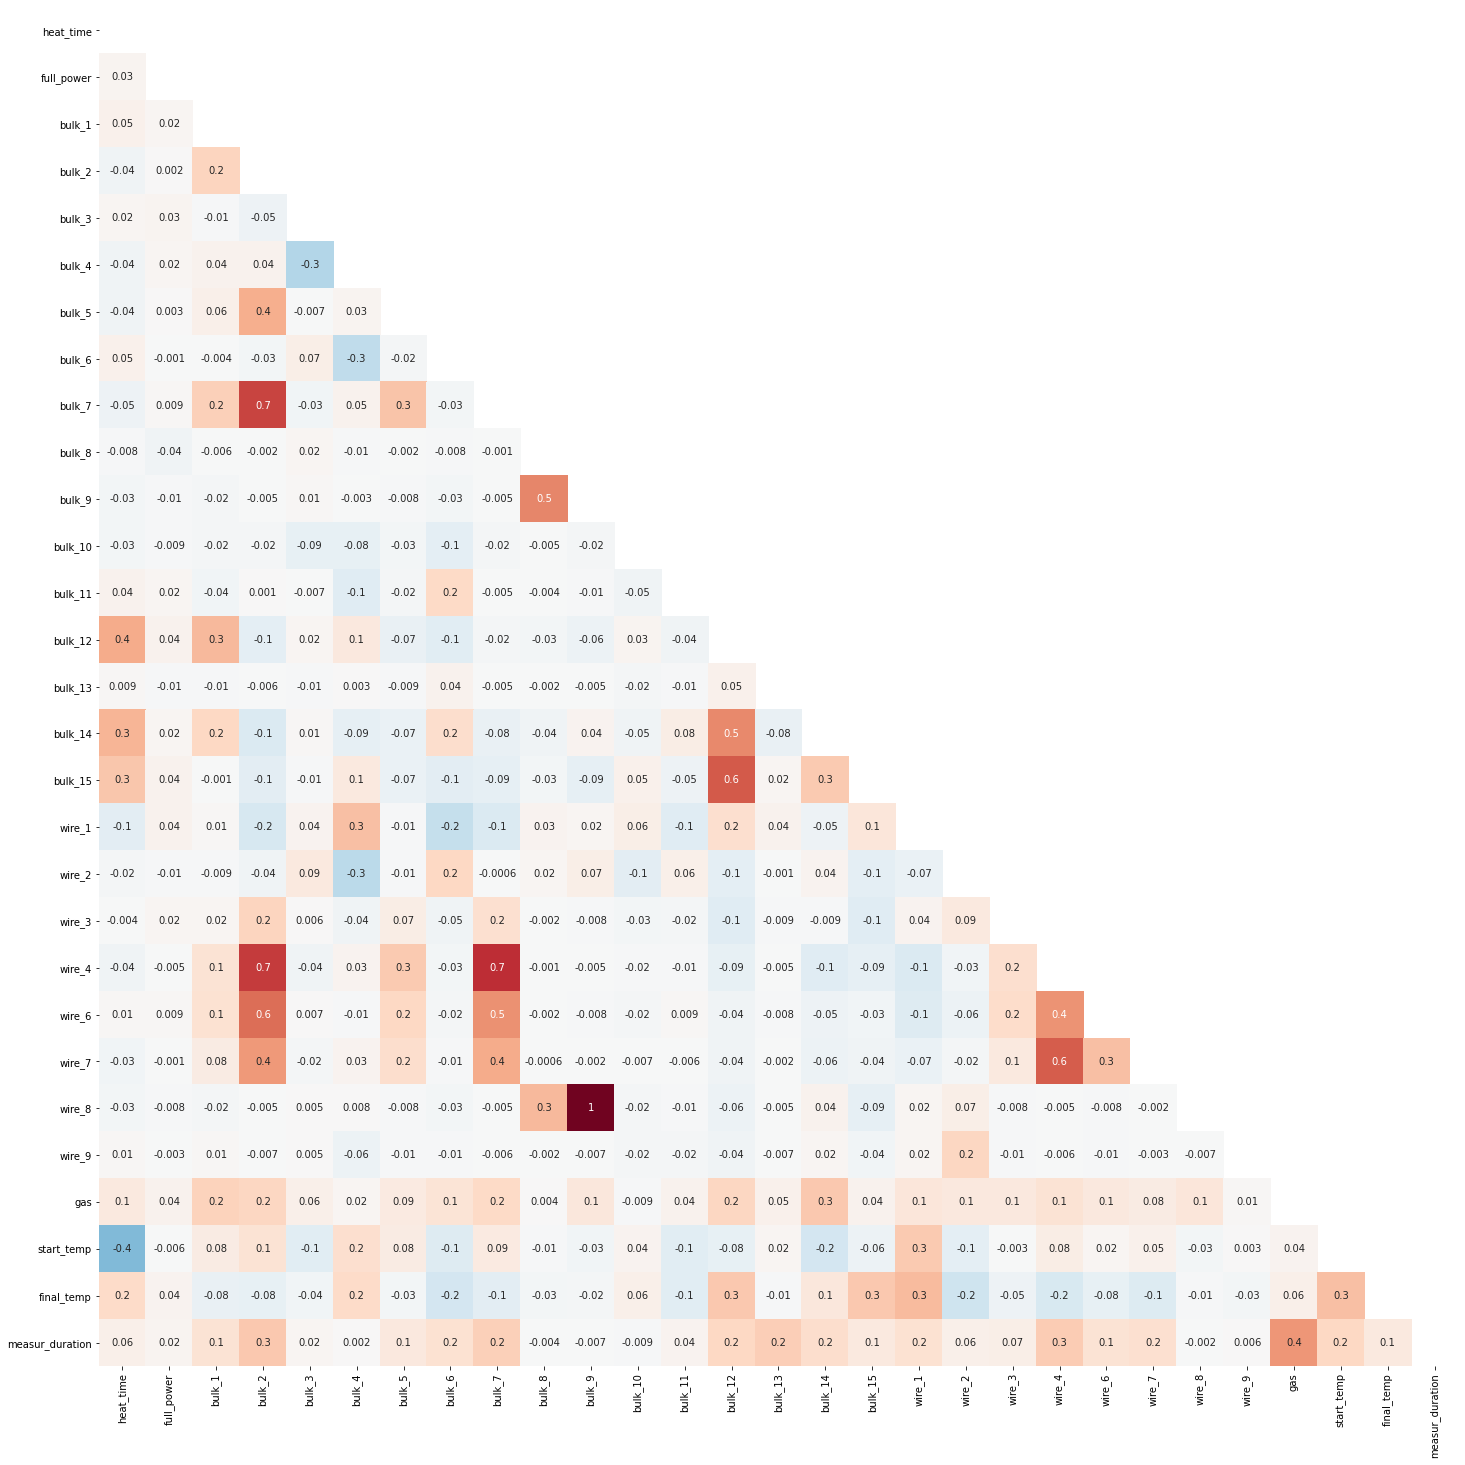

In [50]:
plt.figure(figsize=(25, 25))
matrix = np.triu(data.corr())
heatmap = sns.heatmap(data.corr(),
                      annot=True,
                      mask=matrix,
                      square=True,
                      cmap='RdBu_r',
                      cbar=False,
                      vmin=-1, vmax=1,
                      fmt='.1g');

Оценим корреляцию целевого признака

Корреляция признаков:



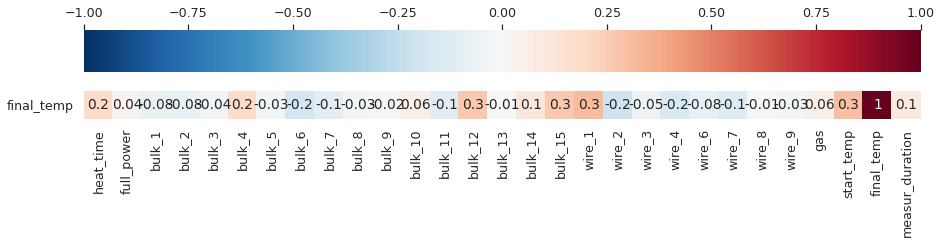


Корреляция между final_temp и heat_time:
Коэффициент корреляции: 0.193524 
 Слабая прямая связь

Корреляция между final_temp и full_power:
Коэффициент корреляции: 0.037525 
 Слабая прямая связь

Корреляция между final_temp и bulk_1:
Коэффициент корреляции: -0.075428 
 Слабая обратная связь

Корреляция между final_temp и bulk_2:
Коэффициент корреляции: -0.082543 
 Слабая обратная связь

Корреляция между final_temp и bulk_3:
Коэффициент корреляции: -0.037156 
 Слабая обратная связь

Корреляция между final_temp и bulk_4:
Коэффициент корреляции: 0.187817 
 Слабая прямая связь

Корреляция между final_temp и bulk_5:
Коэффициент корреляции: -0.028446 
 Слабая обратная связь

Корреляция между final_temp и bulk_6:
Коэффициент корреляции: -0.180906 
 Слабая обратная связь

Корреляция между final_temp и bulk_7:
Коэффициент корреляции: -0.107371 
 Слабая обратная связь

Корреляция между final_temp и bulk_8:
Коэффициент корреляции: -0.026613 
 Слабая обратная связь

Корреляция между final_temp и b

In [51]:
col_del = []

corr_info(data, col_del, 'final_temp')

Удалим один из сильнокоррелирующих признаков

In [52]:
data = data[data['wire_8']==0]

### Создание целевого и вспомогательных признаков

In [53]:
features, target = split_target(data, 'final_temp')

### Создание обучающей и тестовой выборки

In [54]:
features_train, features_test, target_train, target_test = split_data(features, target, 0, 0.25)

Вспомогательные признаки:

features_train - Объектов: 1733 шт., признаков: 28 шт. - 74.99%
features_test - Объектов: 578 шт., признаков: 28 шт. - 25.01%

Целевые признаки:

target_train - Объектов: 1733 шт. - 74.99%
target_test - Объектов: 578 шт. - 25.01%


### Вывод по разделу "Предобработка и подготовка данных для обучения"

* Создали единую таблицу для обучения
    * Данные состоят из 2329 объектов
    * Имеют 1 целевой и 27 вспомогательных признаков
* Создали новые признаки:
    * Время нагрева дугой
    * Полная мощность
    * Начальная температура
    * Финальная температура (целевой признак)
    * Длительность измерений температуры
* Удалили нулевой признак "wire_5"
* Удалили номер партии "key" 
* Оценили корреляцию всех признаков:
    * Полная прямая связь между "wire_8" и "bulk_9", вероятно эти добавки применяются одновременно
    * Удалили один из сильнокоррелирующих признаков - "wire_8"
    * Сильная прямая связь между "wire_4", "bulk_2" и "bulk_7", вероятно эти добавки применяются одновременно в большинстве случаев
* Оценили корреляцию целевого признака:
    * Наибольшая прямая связь с wire_1 start_temp и bulk_12 
    * Наибольшая обратная связь с wire_2 bulk_6 и wire_4
* Создали целевой и вспомогательные признаки
* Создали обучающую и тестовую выборки
    * Тестовая выборка = 25%

## Обучение моделей

Создадим переменную для хранения статистики

In [55]:
stat =[]

### LinearRegression()

In [56]:
%%time

lr = make_pipeline(RobustScaler(), LinearRegression())

lr_params = {'linearregression__normalize':[True, False],
             'linearregression__fit_intercept':[True, False]}

grid_lr = GridSearchCV(lr, param_grid=lr_params, scoring='neg_mean_absolute_error', verbose=1)

grid_lr.fit(features_train, target_train)

mae_lr = abs(grid_lr.best_score_)
stat.append(['LinearRegression', round(mae_lr, 5)])

print('Лучшие параметры модели:')
print(grid_lr.best_params_)
print()
print('MAE:', mae_lr)
print()

Fitting 5 folds for each of 4 candidates, totalling 20 fits
Лучшие параметры модели:
{'linearregression__fit_intercept': True, 'linearregression__normalize': False}

MAE: 6.818117270245554

CPU times: user 1.85 s, sys: 2.44 s, total: 4.29 s
Wall time: 4.22 s


### RandomForestRegressor()

In [57]:
%%time

forest = RandomForestRegressor(random_state=r_state) 

forest_params = {'n_estimators': [120, 200, 300, 500],
                 'max_depth': [8, 15, 30],
                 'min_samples_leaf': [2, 6, 10],
                 'min_samples_split': [2, 5, 15]}

grid_forest = GridSearchCV(forest, forest_params, scoring='neg_mean_absolute_error', cv=5, verbose=1)

grid_forest.fit(features_train, target_train)

mae_forest = abs(grid_forest.best_score_)
stat.append(['RandomForestRegressor', round(mae_forest, 5)])

print('Лучшие параметры модели:')
print(grid_forest.best_params_)
print()
print('MAE:', mae_forest)
print()

Fitting 5 folds for each of 108 candidates, totalling 540 fits
Лучшие параметры модели:
{'max_depth': 15, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 300}

MAE: 6.623978032245641

CPU times: user 14min 24s, sys: 2.12 s, total: 14min 26s
Wall time: 14min 27s


### LGBMRegressor()

In [58]:
%%time

gbm = make_pipeline(RobustScaler(), LGBMRegressor(boosting_type='gbdt', seed=r_state))


gbm_params = {'lgbmregressor__learning_rate':[0.01, 0.05, 0.2],
              'lgbmregressor__n_estimators': [200, 400],
              'lgbmregressor__objective' : ['regression', 'regression_l1', 'mape'], 
              'lgbmregressor__max_depth' : [10, 55, 100]}

grid_gbm = GridSearchCV(gbm, gbm_params, cv=5, scoring='neg_mean_absolute_error', verbose=1)

grid_gbm.fit(features_train, target_train)

mae_gbm = abs(grid_gbm.best_score_)
stat.append(['LGBMRegressor', round(mae_gbm, 5)])

print('Лучшие параметры модели:')
print(grid_gbm.best_params_)
print()
print('MAE:', mae_gbm)
print()

Fitting 5 folds for each of 54 candidates, totalling 270 fits
Лучшие параметры модели:
{'lgbmregressor__learning_rate': 0.05, 'lgbmregressor__max_depth': 10, 'lgbmregressor__n_estimators': 400, 'lgbmregressor__objective': 'mape'}

MAE: 6.521798343130875

CPU times: user 22min 34s, sys: 13.3 s, total: 22min 47s
Wall time: 22min 57s


### CatBoostRegressor()

In [ ]:
%%time

cbr = make_pipeline(RobustScaler(), CatBoostRegressor(silent=True, random_seed=r_state))


cbr_params = {'catboostregressor__learning_rate': [0.01, 0.05, 0.2],
              'catboostregressor__n_estimators': [200, 400, 500],
              'catboostregressor__max_depth' : [2, 5, 10]}

grid_cbr = GridSearchCV(cbr, cbr_params, cv=5, scoring='neg_mean_absolute_error', verbose=1)

grid_cbr.fit(features_train, target_train)

mae_cbr = abs(grid_cbr.best_score_)
stat.append(['CatBoostRegressor', round(mae_cbr, 5)])

print('Лучшие параметры модели:')
print(grid_cbr.best_params_)
print()
print('MAE:', mae_cbr)
print()

Fitting 5 folds for each of 27 candidates, totalling 135 fits


### Анализ моделей

In [ ]:
stat_df = pd.DataFrame(stat, columns =['Модель', 'MAE'])
stat_df['Выполнение задачи'] = stat_df['MAE'] < 6.8
stat_df.sort_values(by='MAE')

Лучшая модель согласно нашему рейтингу - CatBoostRegressor

Проверим ее на тестовой выборке

In [ ]:
stat_final = []

In [ ]:
target_predict_cbr = grid_cbr.best_estimator_.predict(features_test)
mae_test_cbr = mae(target_test, target_predict_cbr)

In [ ]:
stat_final.append(['CatBoostRegressor на тестовой выборке', round(mae_test_cbr, 5)])
stat_final.append(['CatBoostRegressor на кросс-валидации', round(mae_cbr, 5)])

### Проверка модели на адекватность

In [ ]:
for strategy in ['mean', 'median']:
    dummy = DummyRegressor(strategy=strategy)
    dummy.fit(features_train, target_train)   
    predict = dummy.predict(features_test)   
    mae_dummy = mae(target_test, predict)   
    stat_final.append([('DummyRegressor ' + str(strategy)), round(mae_dummy, 5)])

In [ ]:
stat_df_final = pd.DataFrame(stat_final, columns =['Модель', 'MAE'])
stat_df_final['Выполнение задачи'] = stat_df_final['MAE'] < 6.8
stat_df_final

### Вывод по разделу "Обучение моделей"

* Обучили 4 модели:
    * LinearRegression
    * RandomForestRegressor
    * LGBMRegressor'
    * CatBoostRegressor
* Лучший результат показала модель CatBoostRegressor
    * MAE на кросс-валидации: 6.47562
* Протестировали лучшую модель
    * MAE на тестовой выборке: 6.62520
    * Приемлемый результат (критерий MAE < 6.8)
    * Для улучшения результата необходимо подробнее изучить начальные данные и выбросы в них, так же протестировать другие значения параметров выбранных нами моделей, либо попробовать другие модели обучения
* Сравнили нашу модель с "константной" для проверки на адекватность
    * MAE "константной" модели со стратегией "среднее": 8.73724
    * MAE "константной" модели со стратегией "медианое": 8.83737
    * У нашей модели значение MAE значительно лучше, наша модель - адекватна

## Анализ значимости признаков

### Анализ

In [ ]:
best_model = grid_cbr.best_estimator_

In [ ]:
importances_feature = pd.Series(best_model.steps[1][1].feature_importances_,
                        index=features_train.columns).sort_values(ascending=False)
      
fig, ax = plt.subplots(figsize=figsize)
importances_feature.plot.bar(ax=ax)
_ = ax.set_title('Оценка значимости признаков')
_ = ax.set_ylabel('Признаки')
fig.tight_layout()

In [ ]:
print('Количество значимых признаков:', importances_feature[importances_feature > 0].count())

### Вывод по разделу "Анализ значимости признаков"

* Количество значимых признаков для нашей лучшей модели: 24 из 27
    * 3 признака имеют нулевую оценку значимости
* Наиболее значимые признаки:
    * start_temp 
    * heat_time
    * measur_duration
    * wire_1
    * bulk_14   

## Общий вывод

Проведено исследование с целью построить модель, которая предскажет температуру стали.

Основной критерий:
* Значение метрики MAE на тестовой выборке не должно превышать 6.8

Данные состояли из файлов, полученных из разных источников:
* data_arc_new.csv — данные об электродах;
* data_bulk_new.csv — данные о подаче сыпучих материалов (объём);
* data_bulk_time_new.csv — данные о подаче сыпучих материалов (время);
* data_gas_new.csv — данные о продувке сплава газом;
* data_temp_new.csv — результаты измерения температуры;
*  data_wire_new.csv — данные о проволочных материалах (объём);
* data_wire_time_new.csv — данные о проволочных материалах (время).

Исследование проходило в четыре этапа:

1. Подготовка данных:

    * Загрузка данных
    * Изучение и анализ данных
    * Принятые решения по итогам этапа:
        * Все нужные признаки необходимо объеденить в одну **итоговую таблицу** для обучения
        * **Названия признаков** в разных таблицах имеют разный стиль и язык. В итоговой таблице нужно все признаки привести к единому стилю
        * Количество уникальных ключей **"key"** во всех данных разное, они соответствуют разным итерациям обработки
        * **data_arc:** 
            * Создадим признак "время нагрева дугой" (длительность)
            * Создадим признак "полная мощность" и удалим активную и реактивную мощности. Полная мощность рассчитывается по формуле: $S=\sqrt{P^2+Q^2}$, где $S$ - Полная мощность, $P$ - Активная мощность, $Q$ - Реактивная мощность
            * В данных, где по одному ключу больше одного измерения агрегируем по среднему значению
        * **data_bulk и data_wire:**
            * Пропуски в данных заменим на значение 0
        * **data_bulk_time и data_wire_time** - не будем использовать при обучении
        * **data_gas** - оставляем как есть
        * **data_temp:**
            * Содержит целевой признак - финальную температуру
            * Не будем использовать для обучения промежуточные измерения температуры
            * Начальную температуру оставим для обучения в качестве отдельного признака
            * Создадим признак "Длительность замеров"
    

2. Предобработка и подготовка данных для обучения:

    * Проверка типов данных
    * Обработка пропусков
    * Создание единой таблицы
    * Проверка корреляции признаков
    * Удаление признаков, не влияющих на целевой признак
    * Создание целевого и вспомогательных признаков
    * Создание обучающей и тестовой выборки (тестовая выборка = 25%)
    * Итог этапа:
        * Создали единую таблицу для обучения
            * Данные состоят из 2329 объектов
            * Имеют 1 целевой и 27 вспомогательных признаков
        * Создали новые признаки:
            * Время нагрева дугой
            * Полная мощность
            * Начальная температура
            * Финальная температура (целевой признак)
            * Длительность измерений температуры
        * Удалили нулевой признак "wire_5"
        * Удалили номер партии "key" 
        * Оценили корреляцию всех признаков:
            * Полная прямая связь между "wire_8" и "bulk_9", вероятно эти добавки применяются одновременно
            * Удалили один из сильнокоррелирующих признаков - "wire_8"
            * Сильная прямая связь между "wire_4", "bulk_2" и "bulk_7", вероятно эти добавки применяются одновременно в большинстве случаев
        * Оценили корреляцию целевого признака:
            * Наибольшая прямая связь с wire_1 start_temp и bulk_12 
            * Наибольшая обратная связь с wire_2 bulk_6 и wire_4
        * Создали целевой и вспомогательные признаки
        * Создали обучающую и тестовую выборки
            * Тестовая выборка = 25%
    
    
3. Обучение моделей

    * 2-3 простых моделей
    * 2-3 модели градиентного бустинга
    * Анализ обученых моделей и выбор лучшей
    * Тестирование лучшей модели на тестовой выборке
    * Проверка модели на адекватность
    * Итоги этапа:
        * Обучили 4 модели:
            * LinearRegression
            * RandomForestRegressor
            * LGBMRegressor'
            * CatBoostRegressor
        * Лучший результат показала модель CatBoostRegressor
            * MAE на кросс-валидации: 6.47562
        * Протестировали лучшую модель
            * MAE на тестовой выборке: 6.62520
            * Приемлемый результат (критерий MAE < 6.8)
        * Для улучшения результата необходимо подробнее изучить начальные данные и выбросы в них, так же протестировать другие значения параметров выбранных нами моделей, либо попробовать другие модели обучения
        * Сравнили нашу модель с "константной" для проверки на адекватность
            * MAE "константной" модели со стратегией "среднее": 8.73724
            * MAE "константной" модели со стратегией "медианое": 8.83737
            * У нашей модели значение MAE значительно лучше, наша модель - адекватна
    
    
4. Анализ значимости признаков
    * Итоги этапа:
        * Количество значимых признаков для нашей лучшей модели: 24 из 27
            * 3 признака имеют нулевую оценку значимости
        * Наиболее значимые признаки:
            * start_temp 
            * heat_time
            * measur_duration
            * wire_1
            * bulk_14   